# Influence of News Topics on Facebook-based Stress Impact Scores

## Table of Contents

1. [Introduction](#introduction)

2. [Related Work](#related-work)

3. [Setup](#setup)

4. [Data Collection](#data-collection)

5. [Data Analysis](#data-analysis)    
   5.1 [Reaction Bi-Variate Analysis](#reaction-analysis)    
   5.2 [Stress Score Analysis](#stress-score-analysis)

6. [Conclusion](#conclusion)

<a id ="introduction"></a>

## 1. Introduction

The amount of time people spend on social media for e.g., Facebook, Twitter etc. is constantly increasing. Teens now spend up to nine hours a day on social platforms, while 30% of all time spent online is now allocated to social media interaction. And the majority of that time is on mobile - 60% of social media time spent is facilitated by a mobile device. [Source](https://www.socialmediatoday.com/marketing/how-much-time-do-people-spend-social-media-infographic)

With such widespread use of smartphones, the role of social networking websites has greatly transformed. Becoming popular as a fun way to share your vacation pictures with the world, Facebook feed has now turned into a one-stop destination for everything from creepily relevant advertisements to latest news on violence and destruction around the world. How many times have you logged into Facebook with the intention of checking updates from dear ones only to find unpleasant news of politics and violence on top of your news feed? 

Negative news can significantly change an individual’s mood leading to distress and degradation in productivity. In this project, I analyze the potential stress impact of articles shared on Facebook and the variance of this impact based on the broad topic of the news article. Intuitively, an article on violence/war is expected to induce a more negative reaction compared to an article on sports/lifestyle. My initial goal is to validate such hypotheses using Facebook data available publicly. If we do observe significant variations based on news topics, we can potentially incorporate the topic dimension into news recommendation engines. For example, during working hours, the recommendation engine can place low priority for negative news with high stress scores if previous activity by the user for similar news articles is not found.

For the data collection, I utilize Facebook API to collect information including article link, likes and "reactions" information to news articles shared on the official pages of reputed newspapers around the world. Additionally, for each news article, I find out the broad topic category of the article either from the article's link or by scraping the article's main page. With the collected data, I perform various analyses including relationship between the negative and positive reactions to an article and the variance in stress score across news topics. 

For those unfamiliar with Facebook reactions, these are additional emotions one can express for photos, posts and other content on Facebook apart from the "like" option which was the only reaction present previously. The available reactions are shown in the figure below. 

<img src="images/facebook_reactions.png" alt="Smiley face" height="500" width="500">

<a id ="related-work"></a>

## 2. Related Work

While researching during problem formulation of this project, I came across this highly relevant data science blog [MyChillNews: An NLP-driven guide for conscious consumption of stressful news](https://blog.insightdatascience.com/mychillnews-an-nlp-driven-guide-for-conscious-consumption-of-stressful-news-89b4ba78a937). In MyChillNews, the author computed Stress-Impact Scores for news articles using Facebook API data. The author trained machine learning models for stress impact prediction using the article's title words as predictors. Moreover, the author built a web app that scrapes the top headlines from various newspapers' main pages on a daily basis and computes the potential Stress Impact Score using the trained models. All in all, this is a fantastic project and served as motivation for my own analysis.

I found the analysis or active incorporation of news topic into the prediction model to be missing. It is possible a strong machine learning model can self-learn to classify topics based on words in the article titles. In contrast, my goal is to analyze the variance in stress impact scores across news topics without the use of article's title and content.

<a id ="setup"></a>

## 3. Setup

In [2]:
# Data Collection
import urllib.request
import json
import datetime
import csv
import time
import requests
from bs4 import BeautifulSoup

# Data Transformation and Analysis
import numpy as np
import pandas as pd
pd.set_option('precision',10)

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14,10]
import seaborn as sns
%matplotlib inline

<a id ="data-collection"></a>

## 4. Data Collection

For the data collection via Python using Facebook API, I was able to find baseline code available on GitHub. The top three sources I utilized are as follows:

1. [Facebook Page Post Scraper](https://github.com/minimaxir/facebook-page-post-scraper)

2. [MyChillNews](https://github.com/drsaunders/MyChillNews)

The key extensions I performed include:

1. **Extraction of news topics from news article links.** The treatment had to be different for different newspapers. Please go through the __processFacebookPageFeedStatus function of NewspaperData class in the following cell.

2. **Modified computation of stress impact score compared to MyChillNews.** In my definition of stress score, the numerator is the sum of loves, hahas and thankfuls minus the sum of sad and angries. The denominator is the sum of loves, hahas, thankfuls, sads, angries and wows. I decided not to use wows in the numerator as from my anectodal evidence, wow can be used for both positive news and negative news.

3. Minor changes in requests response code and other changes for Python 3.

In [34]:
# Obtain the access token by creating Facebook Developers account
## Obtain App Token for long-term access
## Tutorial: https://medium.com/towards-data-science/how-to-use-facebook-graph-api-and-extract-data-using-python-1839e19d6999

app_id = "xxxx"
app_secret = "xxxx" # DO NOT SHARE WITH ANYONE!

access_token = app_id + "|" + app_secret

In [31]:
class NewspaperData:
    
    def __init__(self, page_id, access_token):
        """NewspaperData initialization

        Args:
            page_id: The FB page to download from.
            access_token: FB developer api token 
        """
        self.page_id = page_id
        self.access_token = access_token
    
    def __unicode_normalize(self, text):
        """ Needed to write tricky unicode correctly to csv
        """
        return text.translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0xa0:0x20 }).encode('utf-8')
    
    def __request_until_succeed(self, url):
        success = False
        while success is False:
            try: 
                response = urllib.request.urlopen(url)
                if response.getcode() == 200:
                    success = True
            except Exception as e:
                print(e)
                time.sleep(5)

                print("Error for URL %s: %s" % (url, datetime.datetime.now()))

        return response.read().decode("utf-8")
    
    def __unshorten_until_succeed(self,url):
        """Handy when links shared on Facebook are in shortened form

        Args:
            url: shortened url link
        """
        try: 
            url = requests.head(url, allow_redirects=True).url
        except Exception as e:
            print(e)
            #time.sleep(5)
            print("Error for URL %s: %s" % (url, datetime.datetime.now()))

        return url
    
    def __getFacebookPageFeedData(self, num_statuses):
        """Gets a list of latest statuses from a particular page.

        Args:
            num_statuses: How many to grab this time
        """
        # construct the URL string
        base = "https://graph.facebook.com/v2.6/"
        node = "/" + self.page_id + "/posts" 
        parameters = "/?fields=message,link,created_time,type,name,id,comments.limit(1).summary(true),shares,reactions.limit(1).summary(true)&limit=%s&access_token=%s" % (num_statuses, self.access_token) # changed
        url = base + node + parameters

        # retrieve data
        data = json.loads(self.__request_until_succeed(url))

        return data
    
    def __getFacebookPostData(self,status_id):
        """Returns all the Facebook API data for a given status

        Args:
            status_id: ID of the particular status to get data for
        """
        num_statuses = 1
        # construct the URL string
        base = "https://graph.facebook.com/v2.6/"
        node = status_id 
        #parameters = "/?fields=reactions.summary(true),reactions.type(LIKE).limit(0).summary(true).as(like),reactions.type(LOVE).limit(0).summary(true).as(love),reactions.type(WOW).limit(0).summary(true).as(wow),reactions.type(HAHA).limit(0).summary(true).as(haha),reactions.type(SAD).limit(0).summary(true).as(sad),reactions.type(ANGRY).limit(0).summary(true).as(angry),reactions.type(THANKFUL).limit(0).summary(true).as(thankful)&limit=%s&access_token=%s" % (num_statuses, access_token) # changed

        #Potentially quicker, but maybe no difference:
        parameters = "/?fields=link,reactions.summary(total_count),reactions.type(LIKE).limit(0).summary(total_count).as(like),reactions.type(LOVE).limit(0).summary(total_count).as(love),reactions.type(WOW).limit(0).summary(total_count).as(wow),reactions.type(HAHA).limit(0).summary(total_count).as(haha),reactions.type(SAD).limit(0).summary(total_count).as(sad),reactions.type(ANGRY).limit(0).summary(total_count).as(angry),reactions.type(THANKFUL).limit(0).summary(total_count).as(thankful)&limit=%s&access_token=%s" % (num_statuses, self.access_token) # changed
        url = base + node + parameters

        # retrieve data
        data = json.loads(self.__request_until_succeed(url))
        #print(data) - for debugging
        return data
    
    def __processFacebookPageFeedStatus(self,status):
        """Takes a single FB status' data and computes all metrics

        Args:
            status: A facebook story retrieved from an API call

        Returns:
            A single row describing the aggregated reactions and metrics to the story.    
        """
        # The status is now a Python dictionary, so for top-level items,
        # we can simply call the key.

        # Additionally, some items may not always exist,
        # so must check for existence first
        #print(status['id'])
        status_id = status['id']

        # To access data on particular reactions, accessing by post was easier than accessing by page.
        # data is returned with each reaction data point.
        # This slows down the script a bit and probably better ways are out there.
        data = self.__getFacebookPostData(status_id)


        status_message = '' if 'message' not in status.keys() else self.__unicode_normalize(status['message'])
        link_name = '' if 'name' not in status.keys() else self.__unicode_normalize(status['name'])
        status_type = status['type']
        #status_link = '' if 'link' not in status.keys() else unicode_normalize(status['link'])
        status_link = '' if 'link' not in status.keys() else status['link']


        # Time needs special care since a) it's in UTC and
        # b) it's not easy to use in statistical programs.

        status_published = datetime.datetime.strptime(status['created_time'],'%Y-%m-%dT%H:%M:%S+0000')
        status_published = status_published + datetime.timedelta(hours=-5) # EST
        status_published = status_published.strftime('%Y-%m-%d %H:%M:%S') # best time format for spreadsheet programs

        # Nested items require chaining dictionary keys.

        #num_reactions1 = 0 if 'reactions' not in status.keys() else status['reactions']['type']['like']#.limit(0).summary(true).as(like)
        num_reactions = 0 if 'reactions' not in status.keys() else status['reactions']['summary']['total_count']
        num_comments = 0 if 'comments' not in status.keys() else status['comments']['summary']['total_count']
        num_shares = 0 if 'shares' not in status.keys() else status['shares']['count']
        num_likes = 0 if 'like' not in data.keys() else data['like']['summary']['total_count']
        num_loves = 0 if 'love' not in data.keys() else data['love']['summary']['total_count']
        num_wows = 0 if 'wow' not in data.keys() else data['wow']['summary']['total_count']
        num_hahas = 0 if 'haha' not in data.keys() else data['haha']['summary']['total_count']
        num_sads = 0 if 'sad' not in data.keys() else data['sad']['summary']['total_count']
        num_angries = 0 if 'angry' not in data.keys() else data['angry']['summary']['total_count']
        num_thankfuls = 0 if 'thankful' not in data.keys() else data['thankful']['summary']['total_count']

        # Stress Impact Score Computation
        sis = 0
        if(num_reactions - num_likes > 0):
            sis = 0.5*(num_loves + num_hahas + num_thankfuls - num_sads - num_angries)/(num_loves + num_wows + num_hahas + num_thankfuls + num_sads + num_angries)

        # News Topic Category Scraping Goes here

        '''
        if 'www.nytimes.com' not in status_link:
            session = requests.Session()  # so connections are recycled
            resp = session.head(status_link, allow_redirects=True)
            status_link = resp.url
        '''

        topic_primary = ''
        topic_secondary = ''
        ny_list = ['nytimes', 'cnn.com']
        wash_list = ['www.washingtonpost.com','theguardian.com','www.latimes.com','timesofindia.indiatimes.com']

        # NY Times:
        if self.page_id == 'nytimes' or self.page_id == 'cnn':
            if not any(x in status_link for x in ny_list):
                status_link = unshorten_until_succeed(status_link)
            if any(x in status_link for x in ny_list):
                link_split = status_link.split('/')
                if len(link_split) > 6:
                    topic_primary = link_split[6]
                    if len(link_split) == 9:
                        topic_secondary = link_split[7]

        # Washington Post
        elif self.page_id in ['washingtonpost', 'theguardian', 'latimes','TimesofIndia']:
            if not any(x in status_link for x in wash_list):
                status_link = self.__unshorten_until_succeed(status_link)
            if any(x in status_link for x in wash_list):
                link_split = status_link.split('/')
                if len(link_split) > 3:
                    topic_primary = link_split[3]
                if self.page_id in ['latimes','TimesofIndia'] and len(link_split) > 5:
                    topic_secondary = link_split[4]

        elif self.page_id == 'usatoday':
            if not 'usatoday.com' in status_link:
                status_link = unshorten_until_succeed(status_link)
            if 'usatoday.com' in status_link:
                link_split = status_link.split('/')
                topic_primary = link_split[4]
                if link_split[5] != '2017':
                    topic_secondary = link_split[5]

        elif self.page_id == 'bbcnews':
            if not 'bbc.co' in status_link:
                status_link = unshorten_until_succeed(status_link)
            if 'bbc.co' in status_link:
                link_split = status_link.split('/')
                if len(link_split) > 4:
                    topics = link_split[4].split('-')
                    if len(topics) >= 2:
                        topic_primary = topics[0]
                        if not topics[1][0] in '0123456789':
                            topic_secondary = topics[1]

        # return a tuple of all processed data
        return (status_id, status_message, link_name, status_type, status_link,
               status_published, num_reactions, num_comments, num_shares, num_likes,
                num_loves, num_wows, num_hahas, num_sads, num_angries, num_thankfuls, sis, topic_primary, topic_secondary)
    
    def scrapeFacebookPageFeedStatus(self,limit = 10000, limited = True, save_csv = True):
        """Gets all the statuses, up to a particular limit, for a public FB page.

        Args:
            page_id: The name of the public page e.g. "HuffingtonPost"
            access_token: FB developer api token 

        Returns:
            A dataframe with a row for each story, and columns as described below.
        """
        with open('%s_facebook_statuses_data.csv' % self.page_id, 'w') as file:

            columns=["status_id", "status_message", "link_name", "status_type", "status_link",
               "status_published", "num_reactions", "num_comments", "num_shares", "num_likes",
                        "num_loves","num_wows","num_hahas","num_sads","num_angries","num_thankfuls",
                    "stress_score","topic"]

            news_pages = ['www.nytimes.com','www.washingtonpost.com','cnn.com', 'usatoday.com',
                         'theguardian.com','www.latimes.com','timesofindia.indiatimes.com']

            if save_csv:
                w = csv.writer(file)
                w.writerow(columns)

            has_next_page = True
            num_processed = 0   # keep a count on how many we've processed
            scrape_starttime = datetime.datetime.now()

            print("Scraping {} Facebook Page: {}\n".format(self.page_id, scrape_starttime))

            statuses = self.__getFacebookPageFeedData(100)
            #print(statuses)

            # Get one "page" of 100 statuses at a time
            new_rows = []
            while has_next_page:
                #check_reaction = 0
                for status in statuses['data']:

                    if(status['created_time'] < '2016-00-00T00:00:00+0000'):
                       print(status['created_time'])
                       has_next_page = False
                       break

                    if(status['type'] == 'link'):
                        status_items = self.__processFacebookPageFeedStatus(status)
                        if save_csv:
                            w.writerow(status_items)
                        new_dict = dict()
                        for i,c in enumerate(columns):
                            new_dict[c] = status_items[i]

                        if new_dict['num_reactions'] - new_dict['num_likes'] > 0:
                            new_rows.append(new_dict)
                            #check_reaction += 1
                            # output progress occasionally to make sure code is not stalling
                            num_processed += 1

                            if num_processed % 100 == 0:
                                print("{} Statuses Processed: {}".format(num_processed, datetime.datetime.now()))
                            if limited == True and num_processed >= limit:
                                has_next_page = False
                            #else:
                            #    print(status['link'])


                #if check_reaction == 0:
                #    print(check_reaction)
                #    has_next_page = False

                # if there is no next page, we're done.
                if 'paging' in statuses.keys():
                    if 'next' in statuses['paging'].keys():
                        statuses = json.loads(self.__request_until_succeed(statuses['paging']['next']))
                else:
                    print('Paging ended!')
                    has_next_page = False


            print("\nDone!\n{} Statuses Processed in {}".format(num_processed, datetime.datetime.now() - scrape_starttime))

            new_statuses = pd.DataFrame(new_rows)
            return new_statuses

In [32]:
guardian = NewspaperData('theguardian',access_token)

In [33]:
guardian_data = guardian.scrapeFacebookPageFeedStatus()

Scraping theguardian Facebook Page: 2017-10-29 20:17:35.946251

100 Statuses Processed: 2017-10-29 20:18:11.354825
200 Statuses Processed: 2017-10-29 20:18:42.578405
300 Statuses Processed: 2017-10-29 20:19:14.111109
400 Statuses Processed: 2017-10-29 20:19:49.148351
500 Statuses Processed: 2017-10-29 20:20:20.808188
600 Statuses Processed: 2017-10-29 20:21:14.159000
700 Statuses Processed: 2017-10-29 20:22:00.231246
Exceeded 30 redirects.
Error for URL http://ebx.sh/1WAWmvL: 2017-10-29 20:22:59.432852
800 Statuses Processed: 2017-10-29 20:24:26.615439
2015-12-31T09:00:00+0000

Done!
821 Statuses Processed in 0:07:24.093920


<a id ="data-analysis"></a>

## 5. Data Analysis

In this sub-section, I analyze the collected data. First, I filter the dataframe by removing topics for which there are less than 25 articles and records with total number of reactions less than 10.

In [36]:
guardian_data.head()

,link_name,num_angries,num_comments,num_hahas,num_likes,num_loves,num_reactions,num_sads,num_shares,num_thankfuls,num_wows,status_id,status_link,status_message,status_published,status_type,stress_score,topic
0,"b""A year on from Trump's pussy grab, nothing h...",47,42,11,90,3,169,18,40,0,0,10513336322_10156114478206323,https://www.theguardian.com/lifeandstyle/2017/...,"b'""It is one year later, and all that\'s diffe...",2017-10-29 17:00:00,link,-0.3227848101,lifeandstyle
1,b'Has America lost its appetite for Curb Your ...,23,249,46,186,9,272,7,33,0,1,10513336322_10156114047201323,https://www.theguardian.com/tv-and-radio/2017/...,b'Has a show about the travails of a privilege...,2017-10-29 16:40:00,link,0.1453488372,tv-and-radio
2,b'Why we need a 21st-century Martin Luther to ...,2,50,18,340,14,379,2,182,0,3,10513336322_10156114322666323,https://www.theguardian.com/technology/2017/oc...,"b""'We are all members of the Church of Technop...",2017-10-29 16:20:00,link,0.3589743590,technology
3,"b""Sasha Velour: 'Drag is darkness turned into ...",5,201,6,1205,368,1589,1,155,0,4,10513336322_10156114348701323,https://www.theguardian.com/tv-and-radio/2017/...,"b'Sasha Velour: ""As an adult I\'ve turned to d...",2017-10-29 16:00:00,link,0.4791666667,tv-and-radio
4,"b'Frida Kahlo: feminist, selfie queen, queer i...",4,206,21,3343,525,3895,0,715,0,3,10513336322_10156114421836323,https://www.theguardian.com/fashion/2017/oct/2...,"b'""Frida Kahlo was one of the first women to u...",2017-10-29 15:40:00,link,0.4900542495,fashion


In [37]:
guardian_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 18 columns):
link_name           821 non-null object
num_angries         821 non-null int64
num_comments        821 non-null int64
num_hahas           821 non-null int64
num_likes           821 non-null int64
num_loves           821 non-null int64
num_reactions       821 non-null int64
num_sads            821 non-null int64
num_shares          821 non-null int64
num_thankfuls       821 non-null int64
num_wows            821 non-null int64
status_id           821 non-null object
status_link         821 non-null object
status_message      821 non-null object
status_published    821 non-null object
status_type         821 non-null object
stress_score        821 non-null float64
topic               821 non-null object
dtypes: float64(1), int64(10), object(7)
memory usage: 115.5+ KB


In [42]:
# Making a copy on which we will perform the transformations

news_df = guardian_data.copy()

In [43]:
# Removing the records with number of reactions less than 10
# Total number of reactions includes the likes so they have to be removed

news_df = (news_df
           .loc[news_df['num_reactions'] - 
                news_df['num_likes'] >= 10,:])

In [44]:
# Removing rows with topics which have a total number of articles less than 25

news_df = (news_df.groupby(['topic'])
              .filter(lambda x: len(x) >= 25))

<a id ="reaction-analysis"></a>

### 5.1 Reaction Analysis

In this sub-section, we analyze the relationship between the different reactions after classifying them into positive and negative reactions. Also, I validate not using "wow" in the Stress score computation by showing that it does not have significant correlation with either positive reaction ratio or negative reaction ratio.

To analyze the relationship between positive reactions and negative reactions, I first compute positive reaction ratio and negative reaction ratio for each record. In short, they are the fractions of the total reactions on the record.

In [45]:
news_df['positive_ratio'] = ((news_df['num_hahas'] + 
                                         news_df['num_loves'] + 
                                         news_df['num_thankfuls']) / (news_df['num_reactions'] - news_df['num_likes']))

news_df['negative_ratio'] = (news_df['num_sads'] + news_df['num_angries']) / (news_df['num_reactions'] - news_df['num_likes'])

news_df['wow_ratio'] = news_df['num_wows'] / (news_df['num_reactions'] - news_df['num_likes'])

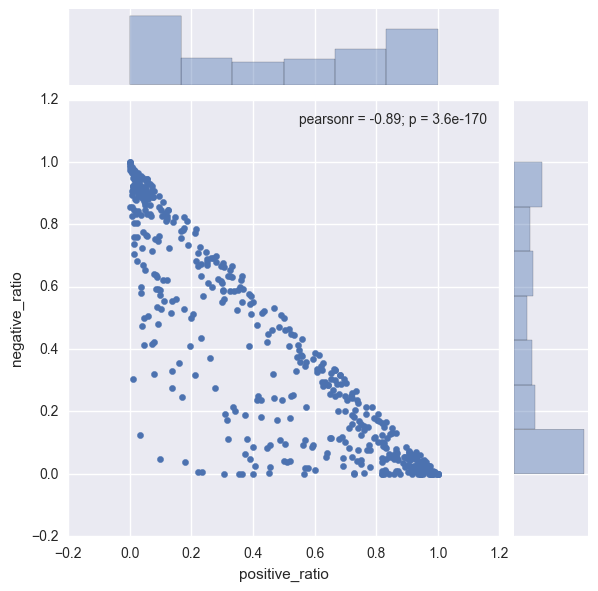

In [46]:
# Positive Reaction ratio - Negative Reaction ratio 
# Bi-variate relationship

sns.jointplot(x = "positive_ratio", y = "negative_ratio", data = news_df)

**Observations:**

1. **Positive reaction distribution:** The biggest bars in the bar plot are at extremely low value of 0 or extremely high value of 1.
2. ** Negative reaction distribution:** The highest bar is at 0 and evenly distributed across other ratio values.
3. **Strong negative correlation:** The Pearson correlation coefficient is a high value of -0.89. From the distribution curves, majority of the points have high positive reaction score or high negative reaction score.

Next, I show wow reaction has little correlation with either the positive reaction ratio or negative reaction ratio.

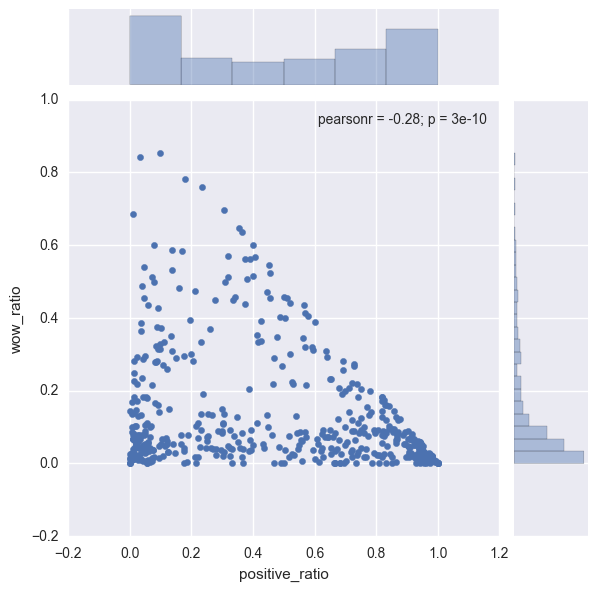

In [47]:
sns.jointplot(x = "positive_ratio", y = "wow_ratio", data = news_df)

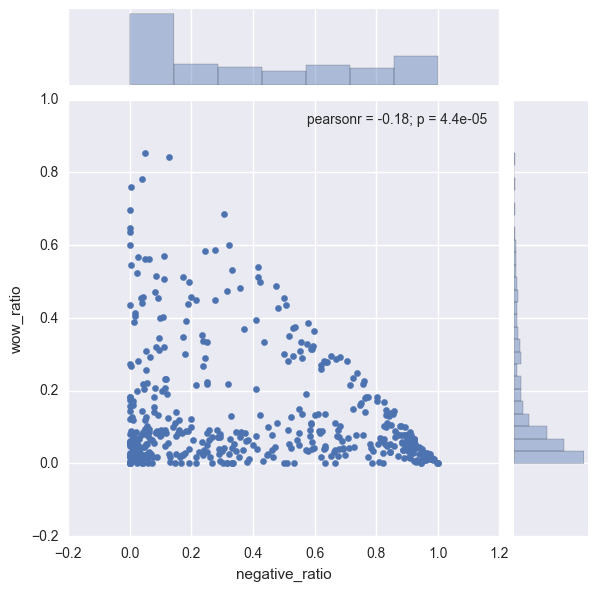

In [48]:
sns.jointplot(x = "negative_ratio", y = "wow_ratio", data = news_df)

<a id ="stress-score-analysis"></a>

## 5.2 Stress Score Analysis

In [51]:
# Listing the top topics based on article count
top_topics = (news_df['topic']
              .value_counts()
              .sort_values(ascending = False)
              .head(10))

top_topics

commentisfree    112
world            102
us-news           81
lifeandstyle      73
politics          54
film              44
technology        32
Name: topic, dtype: int64

commentisfree seems to an irrelevant topic and therefore will be removed from further analysis.

In [63]:
news_df = news_df.loc[news_df['topic'] != 'commentisfree',:]

In [64]:
news_df['topic'].value_counts()

world           102
us-news          81
lifeandstyle     73
politics         54
film             44
technology       32
Name: topic, dtype: int64

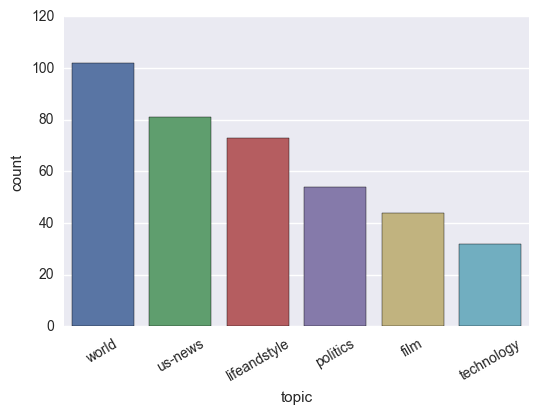

In [65]:
g = sns.countplot(x = "topic", data = news_df, 
              order = (news_df['topic'].
                       value_counts().index))
g.set_xticklabels(g.get_xticklabels(),rotation=30)

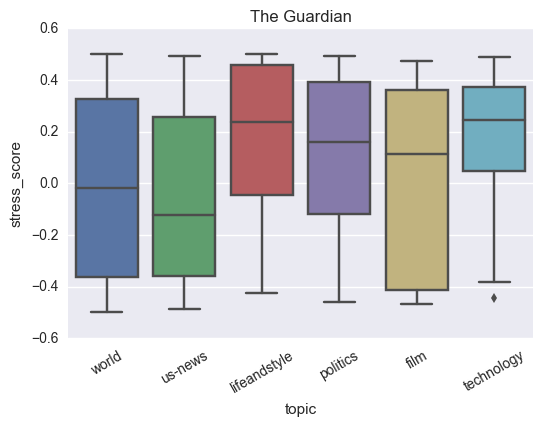

In [68]:
g = sns.boxplot(x = "topic", y = "stress_score", data = news_df,
              order = (news_df['topic'].
                       value_counts().
                       iloc[:].index))
g.set_xticklabels(g.get_xticklabels(),rotation=30)
plt.title("The Guardian")

**Observations:**

1. Technology and Lifestyle topics have the highest positive scores indicating a positive reaction from the readers/

2. Interestingly, politics also has a positive score.

3. Interestingly, film news has the highest variance with the 25%-quantile point lying at -0.4.

4. US News has the lowest mean stress score indicating a higher probability of negative news compared to others. With the US-related news being largely negative ever since the recent elections, this is not surprising.

I performed similar analysis for also LA Times. This will allow us to compare the stress score across news agencies. The plot similar to above is displayed below.

<img src="images/latimes_stress_score.png" alt="Smiley face" height="500" width="500">

**Observations:**

1. We observe high positive scores for sports, food, science and entertainment.

2. Interestingly, world news has the lowest score in this case even lower than politics/business. This might be because the world news might be related to violence and destruction in other parts of the world.

<a id ="conclusion"></a>

## 6. Conclusion

In conclusion, I analyzed Facebook reaction data for news articles shared on the official pages of leading newspapers. My analysis shows a strong negative correlation between positive reaction ratio and negative reaction ratio for an article. Moreover, significant variance was observed in stress score across the different news topics!